<a href="https://colab.research.google.com/github/MtTake/PINNs/blob/main/2D_Navier_Eq_light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 弾性力学の支配方程式

- つり合い式 \\
- 適合条件式(変位-ひずみ関係式)
- 構成式(応力-ひずみ関係式) \\

### 1. つり合い式
　二次元で考えると、

$$
\frac{\partial \sigma_x}{\partial x} + \frac{\partial \tau_{xy}}{\partial y} + X = 0 \\
\frac{\partial \sigma_y}{\partial y} + \frac{\partial \tau_{xy}}{\partial x} + Y = 0 \\
 $$

### 2. 適合条件式

$$
\frac{\partial^2 \epsilon_x}{\partial y^2} + \frac{\partial^2 \epsilon_y}{\partial x^2} = \frac{\partial^2 \gamma_{xy}}{\partial x \partial y} \\
\epsilon_x = \frac{\partial u}{\partial x}, \quad
\epsilon_y = \frac{\partial v}{\partial y}, \quad
\gamma_{xy} = \frac{\partial u}{\partial y} + \frac{\partial v}{\partial x}
$$

### 3. 構成式

$$
\begin {Bmatrix}
       \epsilon_x \\
       \epsilon_y \\
       \epsilon_z \\
       \gamma_{xy} \\
       \gamma_{yz} \\
       \gamma_{zx}
\end {Bmatrix}
= \frac{1}{E}
\begin {bmatrix}
       1 & -v & -v & 0 & 0 & 0 \\
       -v & 1 & -v & 0 & 0 & 0 \\
       -v & -v & 1 & 0 & 0 & 0 \\
       0 & 0 & 0 & 2(1+v) & 0 & 0\\
       0 & 0 & 0 & 0 & 2(1+v) & 0 \\
       0 & 0 & 0 & 0 & 0 & 2(1+v)
\end {bmatrix}
\begin {Bmatrix}
       \sigma_x \\
       \sigma_y \\
       \sigma_z \\
       \tau_{xy} \\
       \tau_{yz} \\
       \tau_{zx}
\end {Bmatrix}
$$

# Navier の方程式

$$
G \left(\nabla^2u_i + \frac{1}{1-2\nu}\frac{\partial \epsilon_i}{\partial x_i}
 + X_i \right) = \rho \frac{\partial^2 u_i}{\partial t^2} \quad (i=1,2,3)
$$

静的釣合い条件では、$i$ を $x,y,z$ で書くと、

$$
\nabla^2u_x + \frac{1}{1-2\nu}\frac{\partial \epsilon_x}{\partial x} + F_x = 0 \\
\nabla^2u_y + \frac{1}{1-2\nu}\frac{\partial \epsilon_y}{\partial y} + F_y = 0 \\
\nabla^2u_z + \frac{1}{1-2\nu}\frac{\partial \epsilon_y}{\partial z} + F_z = 0
$$


# 損失関数

損失関数は、ニューラルネットワークの出力が連続体方程式を満たすようにする．具体的には、以下のような損失関数を定義：

$$ L_{\text{total}} = L_{\text{PDE}} + L_{\text{BC}} + L_{\text{IC}}. $$

- **PDE損失項** $L_{\text{PDE}}$：ネットワークの出力がPDEを満たすようにする損失．具体的には、次の手順で計算：

  1. ネットワークの出力 $u$、$\epsilon$、$X$ から、PDEに必要な偏微分を計算．
  2. PDEの左辺 $\mathcal{L}$ を計算し、その結果がゼロに近くなるようにする．
  3. 損失として、PDEの残差（$\mathcal{L}(u(x,t))$）の二乗和を使用．

$$
L_{\text{PDE}} = \frac{1}{N_{\text{PDE}}} \sum_{j=1}^{N_{\text{PDE}}}  \sum_{i}^{x,y,z} \left(\nabla^2u_{ij} + \frac{1}{1-2\nu}\frac{\partial \epsilon_{ij}}{\partial x_{ij}}
 + X_{ij} \right)^2
$$

- **境界条件損失項** $L_{\text{BC}}$：境界条件を満たすようにする損失

  例えば、$x = 0$ と $x = L$ での境界条件が $u_{BC}(0) = u_L$ と $u_{BC}(L) = u_R$ である場合、次のように計算：

$$
\begin{align}
L_{\text{BC}} &= \frac{1}{N_{\text{BC}}} \sum_{j=1}^{N_{\text{BC}}} \left(u(x_j) - u_{\text{BC}}(x_j) \right)^2 \\
&= \frac{1}{2} \sum_{j=1}^{N_{\text{BC}}} \{ \left( u(x_j=0) - u_{\text{BC}}(x_j=0)\right) + \left( u(x_j=L) - u_{\text{BC}}(x_j=L) \right) \} \\
&= \frac{1}{2} \sum_{j=1}^{N_{\text{BC}}} \{ \left( u(x_j=0) - u_{\text{L}}\right) + \left( u(x_j=L) - u_{\text{R}} \right) \} \\
\end{align}
$$

- **初期条件損失項** $L_{\text{IC}}$：初期条件（例えば、$x=0$ のときの $F_x$ の値）を満たすようにする損失．初期条件損失は次のように書ける：

  $$ L_{\text{IC}} = \frac{1}{N_{\text{IC}}} \sum_{k=1}^{N_{\text{IC}}} \left(F_x(x_k) - F_{x\text{IC}}(x_k) \right)^2, $$

  ここで、$u_{\text{IC}}$ は初期条件に従った値．

# 学習

PINNsのトレーニングは、損失関数 $L_{\text{total}}$ を最小化する．ネットワークの出力がPDE、境界条件、初期条件を満たすように重みが調整される．


In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1234)

In [3]:
num_points = 100

n_in_out = 2
n_make_out = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# ニューラルネットワークの定義
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(n_in_out, 64)
        self.fc2 = nn.Linear(64, 128)
        # self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, n_make_out)
        self.fc5 = nn.Sigmoid()
        self.apply(self.init_weights) # 重み初期化を適用

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight)  # Xavier初期化
            if m.bias is not None:
                init.zeros_(m.bias)  # バイアスはゼロ初期化

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        # x = F.leaky_relu(self.bn2(self.fc2(x)), negative_slope=0.01)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc3(x), negative_slope=0.01)
        x = F.leaky_relu(self.fc4(x), negative_slope=0.01)
        x = self.fc5(x)
        return x

In [5]:
# Navier方程式の計算
def derivatives(u, e, f, x):
    u_x = torch.autograd.grad(outputs=u, inputs=x, grad_outputs=torch.ones_like(u),
                              create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(outputs=u_x[:, 0], inputs=x, grad_outputs=torch.ones_like(u_x[:, 0]),
                               create_graph=True, retain_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(outputs=u_x[:, 1], inputs=x, grad_outputs=torch.ones_like(u_x[:, 1]),
                               create_graph=True, retain_graph=True)[0][:, 1]
    u_e = torch.autograd.grad(outputs=e, inputs=x, grad_outputs=torch.ones_like(e),
                              create_graph=True, retain_graph=True)[0]

    return u_xx + u_yy + 1/(1-2*0.3)*(u_e.sum(dim=1)) + (re_fx.sum(dim=1))

In [6]:
# 損失関数の定義
def loss_function(model, x_bc, u_bc, x_ic, f_ic):

    x_bc = x_bc.to(device)
    u_bc = u_bc.to(device)
    x_ic = x_ic.to(device)
    f_ic = f_ic.to(device)

    # 境界条件損失
    y_bc = torch.rand((2 * N_bc, 1)) * L                # y座標はランダム
    y_bc = y_bc.to(device)
    bc_pred = model(torch.cat((x_bc, y_bc), dim=1))     # MLPを通す
    u_bc_pred = bc_pred[:, :2]                          # 変位を抽出
    loss_bc = torch.mean((u_bc_pred - u_bc)**2)

    # 初期条件損失
    ic_pred = model(x_ic)                               # MLPを通す
    f_ic_pred = ic_pred[:, 4:6]                         # 荷重を抽出
    loss_ic = torch.mean((f_ic_pred - f_ic)**2)

    return loss_bc + loss_ic

In [7]:
# 訓練データの生成
def generate_data(num_points):
    # x と t の範囲を設定
    x_plot = torch.linspace(-L, L, num_points).reshape(-1, 1) # [100, 1]
    y_plot = torch.linspace(-L, L, num_points).reshape(-1, 1) # [100, 1]

    # メッシュグリッドを作成
    # X_g は x_plot の値を列方向に繰り返した行列
    # Y_g は y_plot の値を行方向に繰り返した行列
    # X_g=[100, 100],Y_g=[100, 100]
    X_g, Y_g = torch.meshgrid(x_plot.squeeze(), y_plot.squeeze(), indexing='ij')

    # Flatten 行優先で1行目のあとに2行目を並べる
    # cat dim=1 で全組み合わせ (n,2)
    X_flat = X_g.reshape(-1, 1) # [10000, 1]
    Y_flat = Y_g.reshape(-1, 1) # [10000, 1]

    # gen_data = torch.rand(num_points, 2) * 2 - 1  # [-1, 1]の範囲でサンプルを生成
    gen_data = torch.cat((X_flat, Y_flat), dim=1)

    return gen_data

# ハイパーパラメータ
num_epochs = 10000
learning_rate = 0.001

L = 1.0  # 空間範囲
FX = 1.0  # 荷重
N_bc = 100
N_ic = 100

# モデルの初期化
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# ***** test *******************************************************************
num_points=100                             # サンプル点数
x = generate_data(num_points).to(device)   # サンプル点を生成
x.requires_grad = True                     # 勾配計算を可能にする
u = model(x)                               # モデルの出力を計算

print(x.shape)
print('x=',x[:5])
print(u.shape)
print('u=',u[:5])

re_ux = u[:, :2]                 # 配列を2次元に分離
re_ex = u[:, 2:4]
re_fx = u[:, 4:6]

print('*** Output ***')
print(re_ux.shape)
print('re_ux=',re_ux[:5])
print(re_ex.shape)
print('re_ex=',re_ex[:5])
print(re_fx.shape)
print('re_fx=',re_fx[:5])

# Navier方程式計算
u_x = torch.autograd.grad(outputs=re_ux, inputs=x, grad_outputs=torch.ones_like(re_ux),
                          create_graph=True, retain_graph=True)[0]
# grad_outputs=torch.ones_like(u_x[:, 0])を指定するとxの最初の次元に関する勾配を計算
u_xx = torch.autograd.grad(outputs=u_x[:, 0], inputs=x, grad_outputs=torch.ones_like(u_x[:, 0]),
                            create_graph=True, retain_graph=True)[0][:, 0]
u_yy = torch.autograd.grad(outputs=u_x[:, 1], inputs=x, grad_outputs=torch.ones_like(u_x[:, 1]),
                            create_graph=True, retain_graph=True)[0][:, 1]
u_e = torch.autograd.grad(outputs=re_ex, inputs=x, grad_outputs=torch.ones_like(re_ex),
                          create_graph=True, retain_graph=True)[0]

print('*** Derivatives ***')
print(u_x.shape)
print('u_x=',u_x[:5])
print(u_xx.shape)
print('u_xx=',u_xx[:5])
print(u_yy.shape)
print('u_yy=',u_yy[:5])
print(u_e.shape)
print('u_e=',u_e[:5])
print('u_e.sum=', u_e.sum(dim=1)[:5])
print('u_xx + u_yy + 1/(1-2*0.3)*u_e.sum(dim=1) + re_fx.sum(dim=1)=', (u_xx + u_yy + 1/(1-2*0.3)*(u_e.sum(dim=1)) + (re_fx.sum(dim=1)))[:5])

print('================================================')
# 入力テンソル b を作成（勾配追跡を有効にする）
b = torch.tensor(np.array([[-0.4506,  0.7401], [-0.1686, -0.2135]]), requires_grad=True)

# 出力テンソル a を適当な計算から得る（ここでは b の2乗を例にする）
a = b ** 2  # これは勾配を追跡する

# 勾配計算
grad = torch.autograd.grad(outputs=a, inputs=b, grad_outputs=torch.ones_like(a),
                           create_graph=True, retain_graph=True)[0]

print('grad sample =', grad)  # 結果を表示

print('================================================')
# 可視化用データ作成の確認
x_lwr = torch.full((3, 1), -1)
x_upr = torch.full((3, 1), 1)
y_rnd = torch.rand((2*3, 1)) * 1

x_0 = torch.cat((x_lwr, x_upr), dim=0)
ux_0 = torch.zeros((2 * 3, 1), dtype=torch.float32)
print(x_0)
print(torch.cat((x_0, y_rnd), dim=1))

torch.Size([10000, 2])
x= tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9798],
        [-1.0000, -0.9596],
        [-1.0000, -0.9394],
        [-1.0000, -0.9192]], grad_fn=<SliceBackward0>)
torch.Size([10000, 6])
u= tensor([[0.5207, 0.5065, 0.5188, 0.5202, 0.5042, 0.4998],
        [0.5205, 0.5061, 0.5189, 0.5199, 0.5039, 0.4998],
        [0.5203, 0.5057, 0.5190, 0.5196, 0.5036, 0.4998],
        [0.5200, 0.5052, 0.5192, 0.5194, 0.5034, 0.4998],
        [0.5198, 0.5047, 0.5194, 0.5192, 0.5031, 0.4998]],
       grad_fn=<SliceBackward0>)
*** Output ***
torch.Size([10000, 2])
re_ux= tensor([[0.5207, 0.5065],
        [0.5205, 0.5061],
        [0.5203, 0.5057],
        [0.5200, 0.5052],
        [0.5198, 0.5047]], grad_fn=<SliceBackward0>)
torch.Size([10000, 2])
re_ex= tensor([[0.5188, 0.5202],
        [0.5189, 0.5199],
        [0.5190, 0.5196],
        [0.5192, 0.5194],
        [0.5194, 0.5192]], grad_fn=<SliceBackward0>)
torch.Size([10000, 2])
re_fx= tensor([[0.5042, 0.4998],
        [0.5

In [9]:
total_error_record = []

# 訓練ループ
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    loss_total = 0

    # サンプル点を生成
    x = generate_data(num_points).to(device)
    x.requires_grad = True  # 勾配計算を可能にする

    # モデルの出力を計算
    u = model(x)

    # デコーダからの出力を3次元の座標情報、変位情報と荷重情報に分ける
    re_ux = u[:, :2]                 # 配列を2次元に分離
    re_ex = u[:, 2:4]
    re_fx = u[:, 4:6]

    # Navierの残差を計算
    derivatives_residual = derivatives(re_ux, re_ex, re_fx, x)

    # 損失を計算
    loss_nav = torch.mean(derivatives_residual**2)

    # 境界条件と初期条件のサンプル
    x_bc = torch.cat((torch.full((N_bc, 1), -L), torch.full((N_bc, 1), L)), dim=0) # x=-1,x=1の位置の配列
    u_bc = torch.zeros((2 * N_bc, 1), dtype=torch.float32)                         # x=-1,x=1の境界条件の配列

    x_ic = torch.tensor([[0, 0]], dtype=torch.float32)                             # 荷重点を原点に設定
    f_ic = torch.tensor([[1, 1]], dtype=torch.float32)                             # 荷重をfx=1,fy=1で入れる

    loss_cnd = loss_function(model, x_bc, u_bc, x_ic, f_ic)

    loss = loss_nav + loss_cnd

    loss_total = loss.item()
    total_error_record.append(loss_total)

    # 逆伝播と最適化
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 1.7083754539489746
Epoch 200, Loss: 0.6192771792411804
Epoch 400, Loss: 0.36879879236221313
Epoch 600, Loss: 0.045454077422618866
Epoch 800, Loss: 0.012978682294487953
Epoch 1000, Loss: 0.007630917243659496
Epoch 1200, Loss: 0.005145523697137833
Epoch 1400, Loss: 0.0040000383742153645
Epoch 1600, Loss: 0.003209848655387759
Epoch 1800, Loss: 0.002592268167063594
Epoch 2000, Loss: 0.002272005658596754
Epoch 2200, Loss: 0.0020497252698987722
Epoch 2400, Loss: 0.0018579147290438414
Epoch 2600, Loss: 0.0016903540818020701
Epoch 2800, Loss: 0.001543219666928053
Epoch 3000, Loss: 0.0014155409298837185
Epoch 3200, Loss: 0.001298692892305553
Epoch 3400, Loss: 0.0011854353360831738
Epoch 3600, Loss: 0.0011312159476801753
Epoch 3800, Loss: 0.0010727648623287678
Epoch 4000, Loss: 0.001021533622406423
Epoch 4200, Loss: 0.0009834878146648407
Epoch 4400, Loss: 0.0009550771792419255
Epoch 4600, Loss: 0.0009055376867763698
Epoch 4800, Loss: 0.0008587100892327726
Epoch 5000, Loss: 0.00080

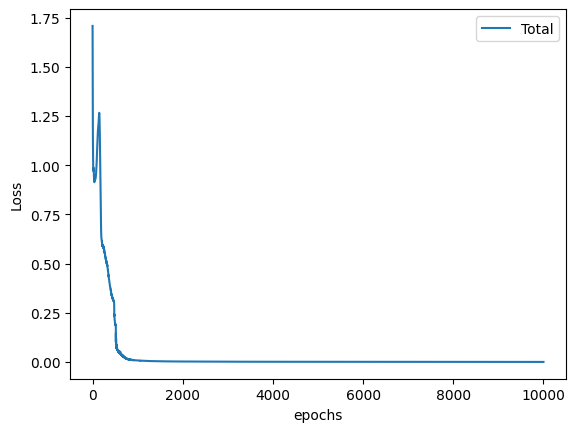

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(total_error_record)+1),total_error_record,label="Total")
plt.legend()

plt.xlabel("epochs")
plt.ylabel("Loss")
plt.show()

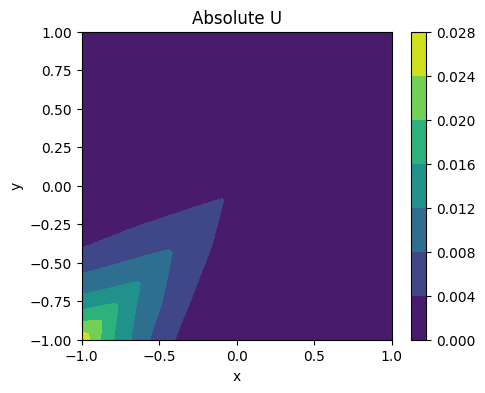

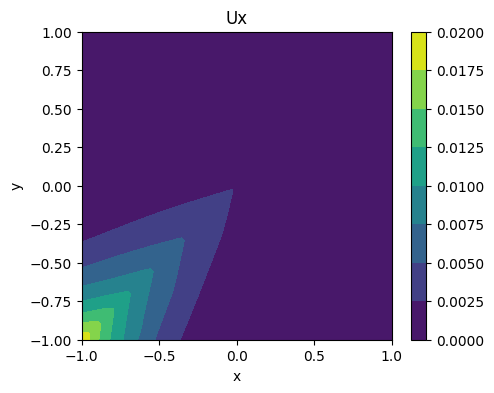

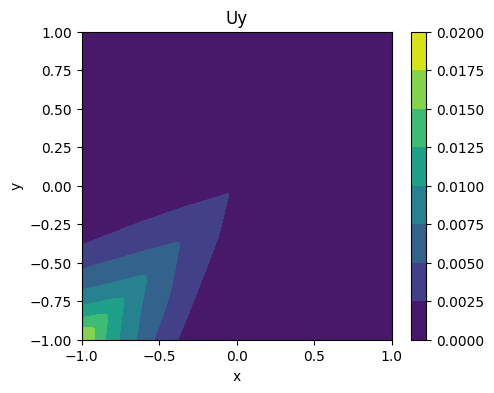

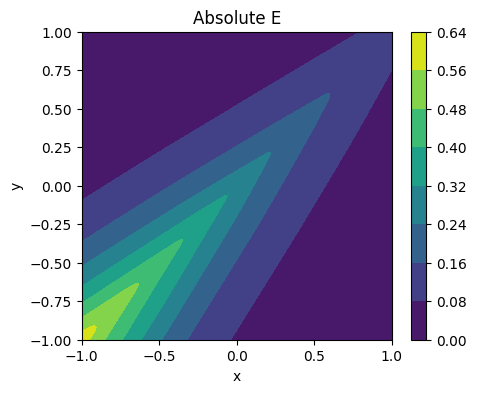

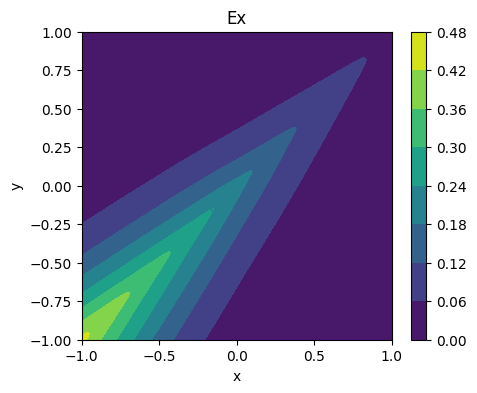

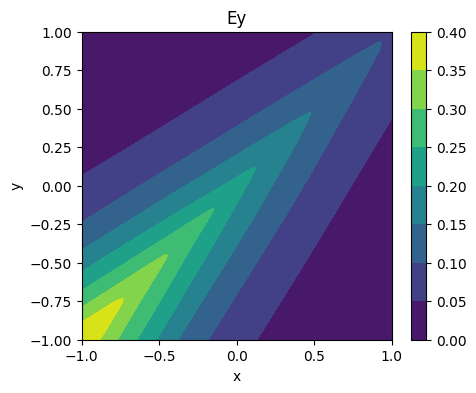

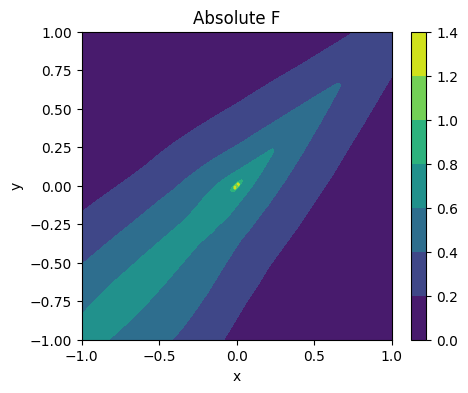

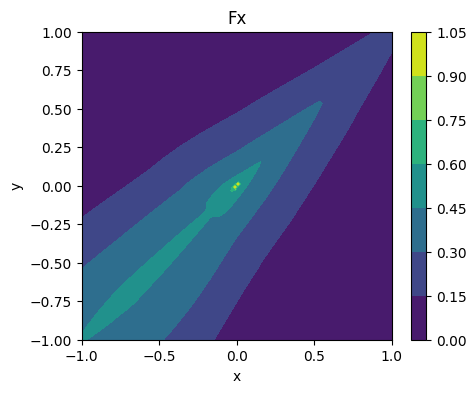

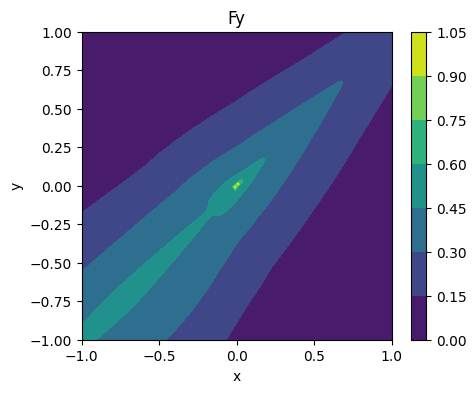

In [17]:
# 結果の可視化
def plot_solution(net, x, y):
    with torch.no_grad():
        net.eval().to(device)
        x = x.to(device)
        y = y.to(device)
        # ネットワークの出力を計算
        # 全組み合わせ[10000, 2]で、出力[10000, 6]を得る
        u = net(torch.cat((x, y), dim=1)).cpu().numpy()
        ux = u[:, :1]
        uy = u[:, 1:2]
        du = np.sqrt(ux**2 + uy**2)
        ex = u[:, 2:3]
        ey = u[:, 3:4]
        de = np.sqrt(ex**2 + ey**2)
        fx = u[:, 4:5]
        fy = u[:, 5:6]
        df = np.sqrt(fx**2 + fy**2)

        # x と t を 1D 配列に変換 ⇒ x= (10000,),t= (10000,)
        x = x.cpu().numpy().flatten()
        y = y.cpu().numpy().flatten()

        # メッシュグリッドの生成
        # 再度、[100, 100]にする、x,tをダブり抜きしてからmeshgrid
        X, Y = np.meshgrid(np.unique(x), np.unique(y))

        # u を 2D 配列に変換 [10000, 1]⇒[100, 100]
        UX = ux.reshape(len(np.unique(y)), len(np.unique(x)))
        UY = uy.reshape(len(np.unique(y)), len(np.unique(x)))
        DU = du.reshape(len(np.unique(y)), len(np.unique(x)))
        EX = ex.reshape(len(np.unique(y)), len(np.unique(x)))
        EY = ey.reshape(len(np.unique(y)), len(np.unique(x)))
        DE = de.reshape(len(np.unique(y)), len(np.unique(x)))
        FX = fx.reshape(len(np.unique(y)), len(np.unique(x)))
        FY = fy.reshape(len(np.unique(y)), len(np.unique(x)))
        DF = df.reshape(len(np.unique(y)), len(np.unique(x)))

        # プロット
        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, DU, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Absolute U')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, UX, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Ux')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, UY, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Uy')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, DE, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Absolute E')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, EX, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Ex')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, EY, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Ey')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, DF, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Absolute F')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, FX, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Fx')
        plt.show()

        plt.figure(figsize=(5, 4))
        contour = plt.contourf(X, Y, FY, cmap='viridis')
        plt.colorbar(contour)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Fy')
        plt.show()

# x と t の範囲を設定
x_plot = torch.linspace(-L, L, 100).reshape(-1, 1) # [100, 1]
y_plot = torch.linspace(-L, L, 100).reshape(-1, 1) # [100, 1]

# メッシュグリッドを作成
# X_g は x_plot の値を列方向に繰り返した行列
# Y_g は y_plot の値を行方向に繰り返した行列
# X_g=[100, 100],Y_g=[100, 100]
X_g, Y_g = torch.meshgrid(x_plot.squeeze(), y_plot.squeeze(), indexing='ij')

# Flatten 行優先で1行目のあとに2行目を並べる
# cat dim=1 で全組み合わせ (n,2)
X_flat = X_g.reshape(-1, 1) # [10000, 1]
Y_flat = Y_g.reshape(-1, 1) # [10000, 1]

# 結果をプロット
plot_solution(model, X_flat, Y_flat)
